<a href="https://colab.research.google.com/github/ericdnbn/housing_price_modeling/blob/master/Housing_Price_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
warnings.filterwarnings("ignore")

# EDA

In [45]:
train_df = pd.read_csv('/content/drive/MyDrive/Haystacks Test Case/Data/train.csv')

In [46]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [47]:
train_df.shape

(1460, 81)

In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Predictors that need to be dropped, because of too many null values – ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [49]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [50]:
target = train_df['SalePrice']

In [51]:
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

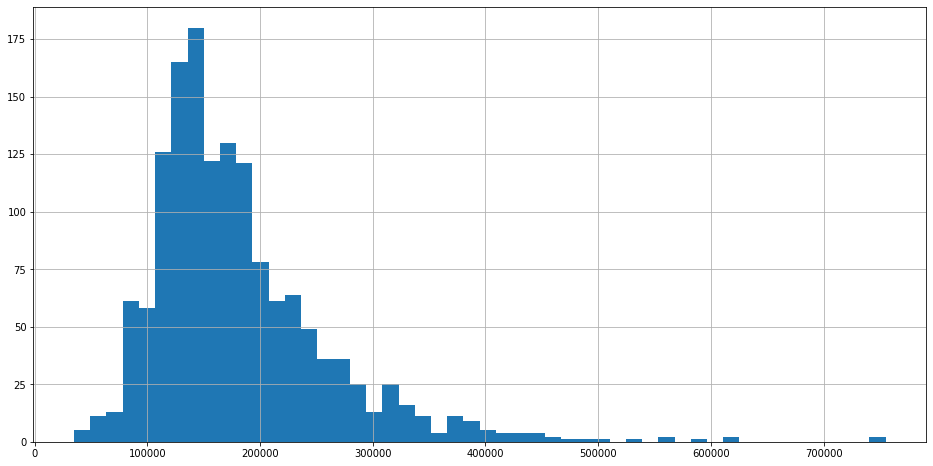

In [52]:
target.hist(figsize=(16,8), bins=50);

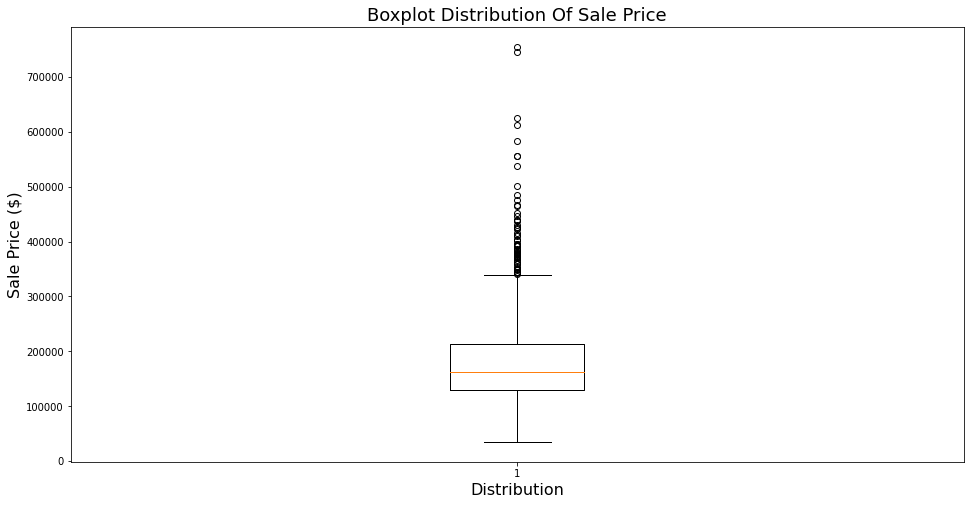

In [53]:
fig, ax = plt.subplots(figsize=(16,8))

ax.boxplot(target)
plt.title('Boxplot Distribution Of Sale Price', fontsize=18)
plt.ylabel('Sale Price ($)', fontsize=16)
plt.xlabel('Distribution', fontsize=16);

In [54]:
train_df.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

In [55]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
train_df_mc = train_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

train_df_mc['pairs'] = list(zip(train_df_mc.level_0, train_df_mc.level_1))

# set index to pairs
train_df_mc.set_index(['pairs'], inplace = True)

# drop level columns
train_df_mc.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
train_df_mc.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
train_df_mc.drop_duplicates(inplace=True)

# reset index for future concatenation
train_df_mc.reset_index(inplace=True)

In [56]:
multicollinear = train_df_mc[(train_df_mc['cc'] > 0.7) & (train_df_mc['cc'] < 1)]
multicollinear

,pairs,cc
1,"(GarageArea, GarageCars)",0.882475
2,"(GarageYrBlt, YearBuilt)",0.825667
3,"(GrLivArea, TotRmsAbvGrd)",0.825489
4,"(TotalBsmtSF, 1stFlrSF)",0.819530
5,"(OverallQual, SalePrice)",0.790982
6,"(SalePrice, GrLivArea)",0.708624


In [57]:
#Only keeping the first four, as the bottom two show correlation between a predictor and the target, not two predictors
multicollinear = multicollinear.iloc[:4]

In [58]:
tup_0 = [tup[0] for tup in multicollinear['pairs']]
tup_1 = [tup[1] for tup in multicollinear['pairs']]

In [59]:
tup_0_corr = [0]

for x in tup_0:
  for i, t in enumerate(train_df_mc['pairs']):
    if 'SalePrice' in t and x in t:
      tup_0_corr.append(train_df_mc.iloc[i]['cc'])

t_0 = pd.Series(tup_0_corr)

tup_1_corr = [0]

for x in tup_1:
  for i, t in enumerate(train_df_mc['pairs']):
    if 'SalePrice' in t and x in t:
      tup_1_corr.append(train_df_mc.iloc[i]['cc'])

t_1 = pd.Series(tup_1_corr)
    

In [60]:
multicollinear = pd.concat([multicollinear, t_0, t_1], axis = 1)
multicollinear.drop([0], axis=0, inplace=True)
multicollinear

,pairs,cc,0,1
1,"(GarageArea, GarageCars)",0.882475,0.623431,0.640409
2,"(GarageYrBlt, YearBuilt)",0.825667,0.486362,0.522897
3,"(GrLivArea, TotRmsAbvGrd)",0.825489,0.708624,0.533723
4,"(TotalBsmtSF, 1stFlrSF)",0.819530,0.613581,0.605852


GaragesCars is more highly correlated with SalePrice than GarageArea, so GarageArea will be dropped.

YearBuilt is more highly correlated with SalePrice than GarageYrBlt, so GarageYrBlt will be dropped.

GrLivArea is more highly correlated with SalePrice than TotRmsAbvGrd, so TotRmsAbvGrd will be dropped.

TotBsmtSF is more highly correlated with SalePrice than 1stFlrSF, so 1stFlrSF will be dropped



In [61]:
num_cols = train_df.select_dtypes(exclude=['object'])

In [62]:
num_cols.shape

(1460, 38)

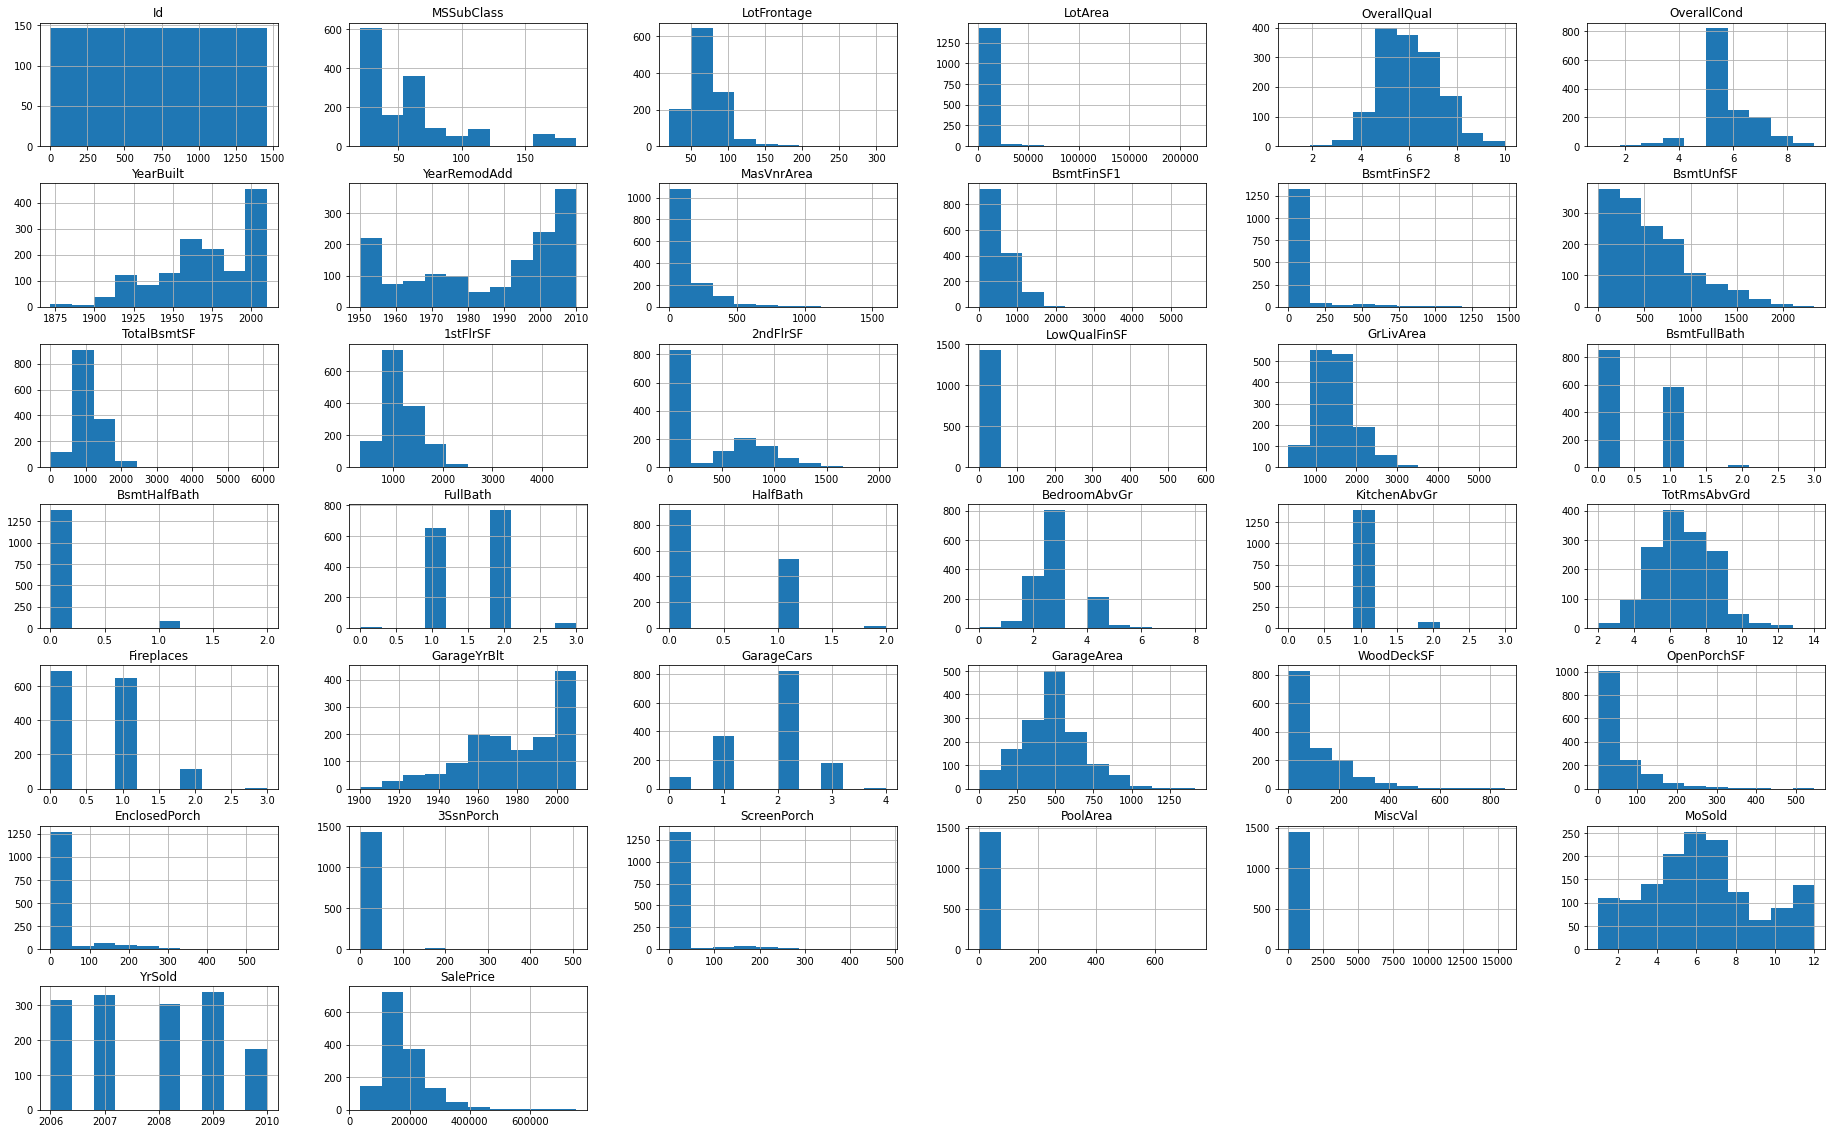

In [63]:
col_list = [col for col in num_cols]
train_df[col_list].hist(figsize=(32,20));

Continuous variables with non-normal distribution ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', ''WoodDeckSF, 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

# Data Preprocessing

In [64]:
# dropping 'Id' column
train_df.drop('Id', axis=1, inplace=True)

In [65]:
# dropping features with too many null values
train_df.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

In [66]:
# dropping multicollinear features
train_df.drop(['GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF'], axis=1, inplace=True)

In [67]:
# dropping MSSubClass feature because it is a categorical variable stored using discreet numerical values, 
# and is made redundant by BldgType, HouseStyle, and YearBuilt
train_df.drop('MSSubClass', axis=1, inplace=True)

In [68]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 70 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1460 non-null   object 
 1   LotFrontage    1201 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

In [69]:
train_df['LotFrontage'].replace(np.NaN, train_df['LotFrontage'].median(), inplace=True)

In [70]:
def replace_NaN(df, features, value):
  for feature in features:
    df[feature].replace(np.NaN, value , inplace=True)

In [71]:
# replacing NaN values in certain garage features to 'U' for Unknown 
replace_NaN(train_df, ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'], 'U')

In [72]:
train_df.dropna(inplace=True)

In [73]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1412 entries, 0 to 1459
Data columns (total 70 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1412 non-null   object 
 1   LotFrontage    1412 non-null   float64
 2   LotArea        1412 non-null   int64  
 3   Street         1412 non-null   object 
 4   LotShape       1412 non-null   object 
 5   LandContour    1412 non-null   object 
 6   Utilities      1412 non-null   object 
 7   LotConfig      1412 non-null   object 
 8   LandSlope      1412 non-null   object 
 9   Neighborhood   1412 non-null   object 
 10  Condition1     1412 non-null   object 
 11  Condition2     1412 non-null   object 
 12  BldgType       1412 non-null   object 
 13  HouseStyle     1412 non-null   object 
 14  OverallQual    1412 non-null   int64  
 15  OverallCond    1412 non-null   int64  
 16  YearBuilt      1412 non-null   int64  
 17  YearRemodAdd   1412 non-null   int64  
 18  RoofStyl

In [74]:
# writing a function to map certain categorical variables to numerical values

cats = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

scale_dict = dict(zip(cats, range(0,6)))

def scale(cat):
  return scale_dict[cat]

In [75]:
def map_function(df, features, function):
  for feature in features:
    df[feature] = train_df[feature].map(lambda x : function(str(x)))

In [76]:
map_function(train_df, ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual'], scale)

In [77]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1412 entries, 0 to 1459
Data columns (total 70 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1412 non-null   object 
 1   LotFrontage    1412 non-null   float64
 2   LotArea        1412 non-null   int64  
 3   Street         1412 non-null   object 
 4   LotShape       1412 non-null   object 
 5   LandContour    1412 non-null   object 
 6   Utilities      1412 non-null   object 
 7   LotConfig      1412 non-null   object 
 8   LandSlope      1412 non-null   object 
 9   Neighborhood   1412 non-null   object 
 10  Condition1     1412 non-null   object 
 11  Condition2     1412 non-null   object 
 12  BldgType       1412 non-null   object 
 13  HouseStyle     1412 non-null   object 
 14  OverallQual    1412 non-null   int64  
 15  OverallCond    1412 non-null   int64  
 16  YearBuilt      1412 non-null   int64  
 17  YearRemodAdd   1412 non-null   int64  
 18  RoofStyl

# Feature Engineering

# Modeling

### *disclaimer* *
It is hard to say with any certainty how the values imputed to the lot frontage predictor will effect the results of the models

In [78]:
x_train = train_df.drop('SalePrice', axis=1)

y_train = train_df['SalePrice']

## Baseline Model

In [79]:
categorical_cols = x_train.select_dtypes('object')
numerical_cols = x_train.select_dtypes(exclude=['object'])

categorical_trans = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])
numerical_trans = Pipeline(steps=[('ss', StandardScaler())])

trans = ColumnTransformer(transformers=[('numerical', numerical_trans, numerical_cols.columns), 
                                        ('categorical', categorical_trans, categorical_cols.columns)
                                        ])

In [81]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

linreg_pipeline = Pipeline(steps=[('trans', trans), 
                                  ('model', LinearRegression(normalize=False))])

# Creating Model
results = linreg_pipeline.fit(x_tr, y_tr)

# Getting Predictions
y_tr_preds = results.predict(x_tr)
y_val_preds = results.predict(x_val)

# Getting R squared scores for training and testing data
y_tr_r2 = r2_score(y_tr, y_tr_preds)
y_val_r2 = r2_score(y_val, y_val_preds)

print(f'R-Squared score for the training data: {y_tr_r2}')
print('')
print(f'R-Squared score for the testing data: {y_val_r2}')
print('')
print('')
     
# Getting Mean Squared Error for training and testing data
y_tr_rmse = mean_squared_error(y_tr, y_tr_preds, squared = False)
y_val_rmse = mean_squared_error(y_val, y_val_preds, squared = False)

print(f'Root Mean Squared Error for the training data: {y_tr_rmse}')
print('')
print(f'Root Mean Squared Error for the testing data: {y_val_rmse}')

R-Squared score for the training data: 0.928147888238396

R-Squared score for the testing data: 0.7080532474007594


Root Mean Squared Error for the training data: 20764.255778754454

Root Mean Squared Error for the testing data: 45561.17004382888


The baseline model shows fairly significant overfitting.

## Linear Regression With l2 regularization

In [82]:
ridge_pipeline = Pipeline(steps=[('trans', trans), 
                                 ('model', Ridge(random_state=42))])

ridge_grid = {'model__alpha': [5.0, 10.0, 15.0, 20.0],
              'model__normalize': [False],
              'model__max_iter': [500,1000,1500,2000],
              'model__tol': [.001, .0001, .00001],
              'model__solver': ['auto', 'sag']}

ridge_gs = GridSearchCV(ridge_pipeline, 
                        ridge_grid, 
                        scoring=['neg_root_mean_squared_error', 'r2'], 
                        refit='neg_root_mean_squared_error', 
                        cv=10, 
                        verbose=3,
                        return_train_score=True)

In [83]:
results = ridge_gs.fit(x_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV 1/10] END model__alpha=5.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001; neg_root_mean_squared_error: (train=-26515.428, test=-22331.779) r2: (train=0.891, test=0.892) total time=   0.1s
[CV 2/10] END model__alpha=5.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001; neg_root_mean_squared_error: (train=-26288.294, test=-25480.513) r2: (train=0.890, test=0.898) total time=   0.1s
[CV 3/10] END model__alpha=5.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001; neg_root_mean_squared_error: (train=-26266.041, test=-26647.852) r2: (train=0.890, test=0.887) total time=   0.1s
[CV 4/10] END model__alpha=5.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001; neg_root_mean_squared_error: (train=-24876.527, test=-39634.415) r2: (train=0.900, test=0.770) total time=   0.1s
[CV 5/10] END model__

In [84]:
results.best_params_

{'model__alpha': 20.0,
 'model__max_iter': 500,
 'model__normalize': False,
 'model__solver': 'auto',
 'model__tol': 0.001}

Best alpha parameter value was 5.0, am going to try new grid with higher values.

In [85]:
results.best_score_

-31295.40649693272

In [86]:
results.best_index_

72

In [87]:
def get_results(results):

  # Function that prints the mean negative rmse from the model that had the lowest mean rmse

  print('The best model parameters produce a mean rmse score on train data of:')
  print(results.cv_results_['mean_train_neg_root_mean_squared_error'][results.best_index_])
  print('')
  print('The best model parameters produce a mean R-squared score on train data of:')
  print(results.cv_results_['mean_train_r2'][results.best_index_])
  print('')
  print('The best model parameters produce a mean rmse score on test data of:')
  print(results.cv_results_['mean_test_neg_root_mean_squared_error'][results.best_index_])
  print('')
  print('The best model parameters produce a mean R-squared score on test data of:')
  print(results.cv_results_['mean_test_r2'][results.best_index_])

In [89]:
get_results(results)

The best model parameters produce a mean rmse score on train data of:
-27287.89036426953

The best model parameters produce a mean R-squared score on train data of:
0.8812698362410897

The best model parameters produce a mean rmse score on test data of:
-31295.40649693272

The best model parameters produce a mean R-squared score on test data of:
0.8333556742094167


### Analysis:

The best parameters for this Ridge regression(linear regression with l2 regularization) included the highest alpha value in the list, the minimum iterations, and what is the default tolerance value.

The best model is slightly overfit to the training data with relation to the validation data, but not too overfit in the broad scope

In [107]:
dt_pipeline = Pipeline(steps=[('trans', trans), 
                              ('model', DecisionTreeRegressor(random_state=42))])

dt_grid = {'model__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
           'model__splitter': ['best', 'random'],
           'model__max_depth': [None, 10],
           'model__min_samples_split': [2, 8],
           'model__min_samples_leaf': [1, 3, 5],
           'model__max_features': ['auto'],
           'model__ccp_alpha': [0.0, 1.0]}

dt_gs = GridSearchCV(dt_pipeline, 
                     dt_grid, 
                     scoring=['neg_root_mean_squared_error', 'r2'], 
                     refit='neg_root_mean_squared_error', 
                     cv=10, 
                     verbose=3,
                     return_train_score=True)

In [108]:
dt_results = dt_gs.fit(x_train, y_train)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
[CV 1/10] END model__ccp_alpha=0.0, model__criterion=squared_error, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best; neg_root_mean_squared_error: (train=-0.000, test=-36491.786) r2: (train=1.000, test=0.711) total time=   0.2s
[CV 2/10] END model__ccp_alpha=0.0, model__criterion=squared_error, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best; neg_root_mean_squared_error: (train=-0.000, test=-39545.662) r2: (train=1.000, test=0.754) total time=   0.3s
[CV 3/10] END model__ccp_alpha=0.0, model__criterion=squared_error, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best; neg_root_mean_squared_error: (train=-0.000, test=-34784.948) r2: (train=1.000, test=0.808) total time=   0.2s
[CV 4/10] END model__cc

In [109]:
dt_results.best_params_

{'model__ccp_alpha': 0.0,
 'model__criterion': 'absolute_error',
 'model__max_depth': 10,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 3,
 'model__min_samples_split': 8,
 'model__splitter': 'best'}

In [110]:
get_results(dt_results)

The best model parameters produce a mean rmse score on train data of:
-18625.936938119754

The best model parameters produce a mean R-squared score on train data of:
0.9445120668613161

The best model parameters produce a mean rmse score on test data of:
-36924.68649259253

The best model parameters produce a mean R-squared score on test data of:
0.7762482689918284


### Analysis

The best parameters for the decision tree regressor were the default ccp_alpha value, absolute error for split criteria, a max model depth set to 10(could be interesting to play with this value in the future), a min samples leaf value greater than 1, a min samples split value greater than 2, and the 'best' splitter method.

The best model in the grid is considerably overfit to the training data both relative to the validation data as well as to the test set

In [114]:
rf_pipeline = Pipeline(steps=[('trans', trans), 
                              ('model', RandomForestRegressor(random_state=42))])

rf_grid = {'model__n_estimators': [50, 150],
           'model__criterion': ['squared_error', 'absolute_error', 'poisson'],
           'model__max_depth': [None, 10],
           'model__min_samples_split': [2, 8],
           'model__min_samples_leaf': [1, 3, 5],
           'model__max_features': ['auto'],
           'model__warm_start': [True, False],
           'model__ccp_alpha': [0.0, 1.0]}

rf_gs = GridSearchCV(rf_pipeline, 
                     rf_grid, 
                     scoring=['neg_root_mean_squared_error', 'r2'], 
                     refit='neg_root_mean_squared_error', 
                     cv=10, 
                     verbose=3,
                     return_train_score=True)

In [115]:
rf_results = rf_gs.fit(x_train, y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
[CV 1/10] END model__ccp_alpha=0.0, model__criterion=squared_error, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, model__warm_start=True; neg_root_mean_squared_error: (train=-11697.103, test=-24911.510) r2: (train=0.979, test=0.865) total time=   4.6s
[CV 2/10] END model__ccp_alpha=0.0, model__criterion=squared_error, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, model__warm_start=True; neg_root_mean_squared_error: (train=-11880.689, test=-26984.187) r2: (train=0.977, test=0.885) total time=   4.6s
[CV 3/10] END model__ccp_alpha=0.0, model__criterion=squared_error, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, model__warm_start=True; neg_root_mean_squared_error: (train=-11736.414,

It seems that as the model iterates through more candidates, it is beginning to overfit less.

However, it appears that there is at least one fold per candidate that returns an r-squared value below .08. This could potentially be caused by model overfitting on the outliers.

The 'poisson' criteria seems to be resulting in significant overfitting as the train r-squared scores are ~.96 while the validation r-squared scores are between 0.8 and 0.6 for the most part.


In [116]:
rf_results.best_params_

{'model__ccp_alpha': 0.0,
 'model__criterion': 'absolute_error',
 'model__max_depth': None,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 150,
 'model__warm_start': True}

In [117]:
get_results(rf_results)

The best model parameters produce a mean rmse score on train data of:
-11258.237730319917

The best model parameters produce a mean R-squared score on train data of:
0.9797945009191737

The best model parameters produce a mean rmse score on test data of:
-28784.579347712937

The best model parameters produce a mean R-squared score on test data of:
0.864390901770325


In [128]:
xgb_pipeline = Pipeline(steps=[('trans', trans), 
                              ('model', XGBRegressor(random_state=42))])

xgb_grid = {'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10],
            'model__booster' : ['gbtree', 'gblinear', 'dart'],
            'model__reg_alpha' : [.01, .001],
            'model__reg_lambda' : [.01, .001]}

xgb_gs = GridSearchCV(xgb_pipeline, 
                      xgb_grid, 
                      scoring=['neg_root_mean_squared_error', 'r2'], 
                      refit='neg_root_mean_squared_error', 
                      cv=10, 
                      verbose=3,
                      return_train_score=True)

In [129]:
xgb_results = xgb_gs.fit(x_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[06:02:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/10] END model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=0.01, model__reg_lambda=0.01; neg_root_mean_squared_error: (train=nan, test=nan) r2: (train=nan, test=nan) total time=   0.1s
[06:02:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/10] END model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alpha=0.01, model__reg_lambda=0.01; neg_root_mean_squared_error: (train=nan, test=nan) r2: (train=nan, test=nan) total time=   0.1s
[06:02:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/10] END model__booster=gbtree, model__max_depth=None, model__n_estimators=100, model__reg_alph

In [125]:
xgb_results.best_params_

{'model__booster': 'gblinear',
 'model__max_depth': None,
 'model__n_estimators': 100,
 'model__reg_alpha': 0.01,
 'model__reg_lambda': 0.01}

In [126]:
get_results(xgb_results)

The best model parameters produce a mean rmse score on train data of:
-26943.37219341011

The best model parameters produce a mean R-squared score on train data of:
0.8842588751809289

The best model parameters produce a mean rmse score on test data of:
-31083.57349851023

The best model parameters produce a mean R-squared score on test data of:
0.836437484614005
